# Simple example of Metropolis-Hastings Algorithm

We look at a simple example of the MH algorithm for computing a posterior using Markov Chain Monte Carlo. We do not use any external code libraries so as to go through every step.

In the example below we generate a chain for a Gaussian model (μ only, σ is fixed) to a data set drawn from a Gaussian to obtain a posterior distribution.

In [1]:
# Setting up packages
from scipy.stats import norm
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [2]:
# Generate fake data set (Gaussian centered at zero)
n_data = 500 # Try also 5000: what happens?
# Number of steps for the chain to "forget" the initial value
burnin = 100
# Picking a seed for the pseudo-random number generator, for reproducibility
np.random.seed(100100)
data = np.random.randn(n_data)

#Parameters for the MCMC-MH method
prop_width = 0.1 # Width (sigma) of proposed step from current step
chain = [0.5]    # Starting value of chain
rejected = 0     # Track number of rejected proposals to compute rejection rate

def gaussian(x, amplitude, mean, sigma):
    return amplitude*(1/(sigma*(np.sqrt(2*np.pi))))*(np.exp(-((x-mean)**2)/((2*sigma)**2)))

def get_bin_centers(values):
    return [(values[i]+values[i+1])*0.5 for i in range(len(values)-1)]

In [3]:
def build_chain(data, chain = [0.5], prop_width = 0.1, burnin = 100, chain_size = 1000):

    rejected = 0
    while len(chain) < chain_size :

        # Picking last element of the chain (from end) as mu
        current_mu = chain[-1]
        proposed_mu = norm(current_mu, prop_width).rvs() # propose step

        # Likelihoods
        current_lh = norm(current_mu, 1).pdf(data).prod()
        proposed_lh = norm(proposed_mu, 1).pdf(data).prod()

        # Priors
        current_prior = norm(0, 1).pdf(current_mu)
        proposed_prior = norm(0, 1).pdf(proposed_mu)

        # Numerator of Bayes formula
        current_p = current_lh * current_prior
        proposed_p = proposed_lh * proposed_prior

        # Acceptance factor: ratio of posteriors
        acceptance_factor = proposed_p / current_p
        # Drawing random number and comparing it with acceptance factor
        accept = np.random.rand() < acceptance_factor        

        if accept:
            chain.append(proposed_mu) # Add accepted proposal to chain
        else:
            rejected+=1
            chain.append(current_mu) # Note: store a value *anyway*!

    print("Rejection rate: {:.2f}%".format(100.*rejected / len(chain)))
    return chain

Rejection rate: 52.20%


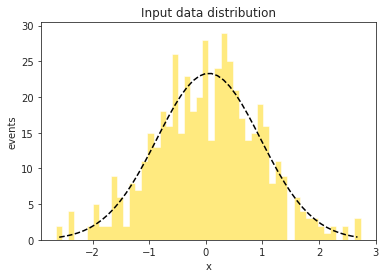

In [4]:
chain = build_chain(data, chain = chain, prop_width = prop_width, burnin = burnin, chain_size = 1000)

# Plotting results
n, bins, patches = plt.hist(data, bins=50, histtype='stepfilled', facecolor='gold', alpha=0.5)
plt.xlabel('x')
plt.ylabel('events')
plt.title('Input data distribution')

popt_gauss, pcov_gauss = curve_fit(gaussian, get_bin_centers(bins), n, p0=[1, 0, 1])
plt.plot(get_bin_centers(bins), gaussian(get_bin_centers(bins), *popt_gauss), 'k--')

plt.show()

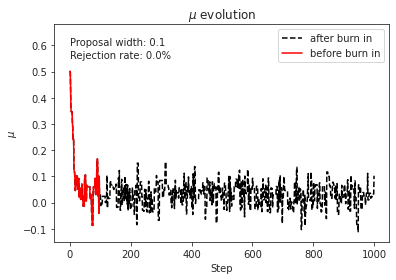

In [5]:
plt.plot(chain, 'k--', label='after burn in')
plt.plot(chain[:burnin], 'r-', label='before burn in')
plt.xlabel('Step')
plt.ylabel('$\mu$')
plt.title('$\mu$ evolution')
plt.ylim(-0.15, 0.68)
plt.text(0, 0.6, 'Proposal width: {}'.format(prop_width))
plt.text(0, 0.55, 'Rejection rate: {}%'.format(100 * rejected / len(chain)))
plt.legend()
plt.show()

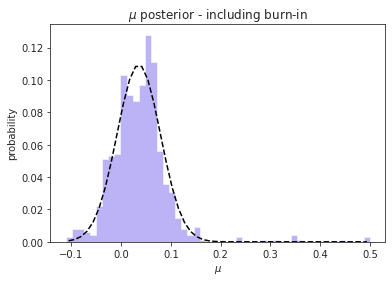

In [6]:
n, bins, patches = plt.hist(chain, bins=50, weights=np.ones_like(chain)/len(chain),
                            histtype='stepfilled', facecolor='mediumslateblue', alpha=0.5)

popt_gauss, pcov_gauss = curve_fit(gaussian, get_bin_centers(bins), n, p0=[1, 0, 1])
plt.plot(get_bin_centers(bins), gaussian(get_bin_centers(bins), *popt_gauss), 'k--')

plt.xlabel('$\mu$')
plt.ylabel('probability')
plt.title('$\mu$ posterior - including burn-in')
plt.show()

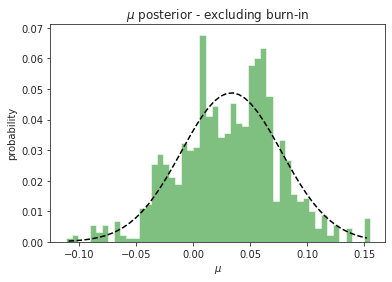

In [7]:
n, bins, patches = plt.hist(chain[burnin:], bins=50, weights=np.ones_like(chain[burnin:])/len(chain[burnin:]),
                            histtype='stepfilled', facecolor='g', alpha=0.5)

popt_gauss, pcov_gauss = curve_fit(gaussian, get_bin_centers(bins), n, p0=[1, 0, 1])
plt.plot(get_bin_centers(bins), gaussian(get_bin_centers(bins), *popt_gauss), 'k--')

plt.xlabel('$\mu$')
plt.ylabel('probability')
plt.title('$\mu$ posterior - excluding burn-in')
plt.show()

# Exercises

1. Adjust the step size (`prop_width`), e.g. to 0.01 and 0.5. What do you observe ?
2. Try to adjust the number of data points. What happens ? Can the code be modified to change this ?